In [25]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import keras.backend as Keras
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale= 1)

In [26]:
Keras.clear_session()

In [27]:
# Creamos los generadores de imagenes de entrenamiento, validación y prueba
# Reescalamos los pixeles con valores entre 0 y 1 y aplicamos tranformaciones a la imagenes

train_datagen = ImageDataGenerator(
    rescale= 1./ 255, 
    shear_range= 0.2,  
    zoom_range= 0.2,        
    horizontal_flip= True
) 

datagen = ImageDataGenerator(rescale= 1./ 255)

train_generator = train_datagen.flow_from_directory(
    directory= '../input/imagenes/train/',
    target_size= (150, 150),
    color_mode= "rgb", # 3 canales 
    batch_size= 32,
    class_mode= "categorical" # one-hot encoded
)

valid_generator = datagen.flow_from_directory(
    directory= '../input/imagenes/val/',
    target_size= (150, 150),
    color_mode= "rgb",
    batch_size= 32,
    class_mode= "categorical"
)

test_generator = datagen.flow_from_directory(
    directory= '../input/imagenes/test/',
    target_size= (150, 150),
    color_mode= "rgb",
    batch_size= 30,
    class_mode= "categorical",
    shuffle= False
)

# Parámetros 
STEP_SIZE_TRAIN= train_generator.n // train_generator.batch_size # Número de pasos que ejecutaremos para entrenar
STEP_SIZE_VALID= valid_generator.n // valid_generator.batch_size # Número de pasos que ejecutaremos para validar
STEP_SIZE_TEST= test_generator.n // test_generator.batch_size # Número de pasos que ejecutaremos para pruebas
NUM_CLASSES = train_generator.num_classes # Número de clases totales para la clasificación

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


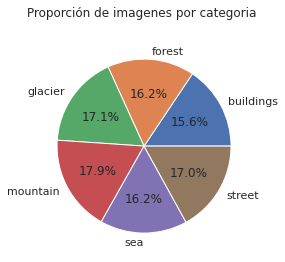

In [28]:
# Analizamos el porcentaje de imagenes de cada categoria

train_images_per_class = np.unique(train_generator.classes, return_counts= True) 

plt.pie(train_images_per_class[1],
        labels= train_generator.class_indices.keys(),
        autopct= '%1.1f%%')

plt.title('Proporción de imagenes por categoria \n')
plt.show()

In [30]:
# Creamos el modelo

model= Sequential()

# BLOQUE 1
model.add(Conv2D(32, (3, 3), input_shape= (150, 150, 3), activation= 'relu')) # 32 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(Conv2D(32, (3, 3), activation= 'relu')) # 32 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(MaxPooling2D((2, 2))) # Tamaño de la ventana de agrupación -> 2x2

# BLOQUE 3
model.add(Conv2D(64, (3, 3), activation= 'relu')) # 64 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(Conv2D(64, (3, 3), activation= 'relu')) # 64 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(MaxPooling2D((2, 2))) # Tamaño de la ventana de agrupación -> 2x2

# BLOQUE 3
model.add(Conv2D(128, (3, 3), activation= 'relu')) # 128 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(MaxPooling2D((2, 2))) # Tamaño de la ventana de agrupación -> 2x2

# BLOQUE 3
model.add(Conv2D(256, (3, 3), activation= 'relu')) # 256 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(MaxPooling2D((2, 2))) # Tamaño de la ventana de agrupación -> 2x2

# BLOQUE 3
model.add(Conv2D(512, (3, 3), activation= 'relu')) # 512 filtros con un tamaño de 3x3 y función de activación ReLu
model.add(MaxPooling2D((2, 2))) # Tamaño de la ventana de agrupación -> 2x2

# BLOQUE 5
model.add(Flatten()) # Convertimos los elementos de la matriz de imagenes en un array de una sola dimensión

#BLOQUE 6
model.add(Dense(1024, activation= 'relu')) # Fully connected
model.add(Dropout(0.4)) # Desactivamos un 40% de las neuronas para reducir el sobreajuste
model.add(Dense(512, activation= 'relu')) # Fully connected
model.add(Dropout(0.5)) # Desactivamos un 50% de las neuronas para reducir el sobreajuste
model.add(Dense(NUM_CLASSES, activation= 'softmax')) # Fully connected -> número de neuronas = número de clases

model.compile(optimizer= Adam(lr= 0.0001), #factor de aprendizaje
              loss= 'categorical_crossentropy',
              metrics= 'accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [31]:
# Entrenamiento del modelo

Model = model.fit(train_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        validation_data= valid_generator,
        validation_steps= STEP_SIZE_VALID,
        epochs= 20,
        callbacks = [EarlyStopping(monitor= 'val_loss', patience= 3), 
                     ModelCheckpoint (filepath = '/kaggle/working/ModeloII.h5', monitor = 'val_loss', save_best_only = True)] # Monotorizamos la función de coste de los datos de validación y guardamos el mejor modelo, minimizando la función de pérdida con respecto a cada 2 épocas 
)

Epoch 1/20
350/350 [==============================] - 97s 278ms/step - loss: 1.3392 - accuracy: 0.4385 - val_loss: 1.1408 - val_accuracy: 0.5392
Epoch 2/20
350/350 [==============================] - 95s 273ms/step - loss: 1.0227 - accuracy: 0.5978 - val_loss: 0.8753 - val_accuracy: 0.6559
Epoch 3/20
350/350 [==============================] - 99s 283ms/step - loss: 0.9003 - accuracy: 0.6582 - val_loss: 0.8236 - val_accuracy: 0.6882
Epoch 4/20
350/350 [==============================] - 105s 299ms/step - loss: 0.8141 - accuracy: 0.6925 - val_loss: 0.7843 - val_accuracy: 0.7108
Epoch 5/20
350/350 [==============================] - 103s 294ms/step - loss: 0.7571 - accuracy: 0.7164 - val_loss: 0.7242 - val_accuracy: 0.7468
Epoch 6/20
350/350 [==============================] - 101s 289ms/step - loss: 0.6963 - accuracy: 0.7449 - val_loss: 0.6086 - val_accuracy: 0.7809
Epoch 7/20
350/350 [==============================] - 105s 301ms/step - loss: 0.6503 - accuracy: 0.7680 - val_loss: 0.5832 - va

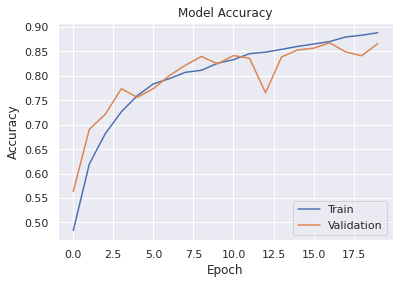

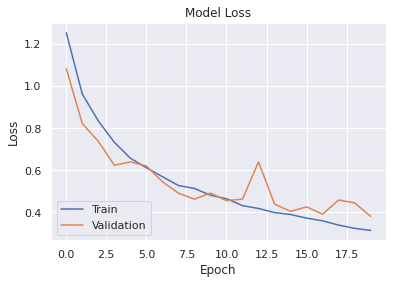

In [9]:
# Creamos dos gráficas y comparamos la exactitud y la pérdida con respecto a los datos de entrenamiento y validación

# Gráfica accuracy

plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Gráfica loss

plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

In [29]:
# Guardamos el modelo entrenado

model.save('/kaggle/working/ModeloII.h5')

In [12]:
# Cargamos el modelo

modelLoad = keras.models.load_model('/kaggle/working/ModeloII.h5')

In [13]:
# Evaluamos el modelo con los datos de prueba

results = modelLoad.evaluate(test_generator, steps= STEP_SIZE_TEST)
print("Loss: {} Accuracy: {}".format(results[0], results[1] * 100))

100/100 [==============================] - 23s 230ms/step - loss: 0.3926 - accuracy: 0.8623
Loss: 0.39264804124832153 Accuracy: 86.2333357334137


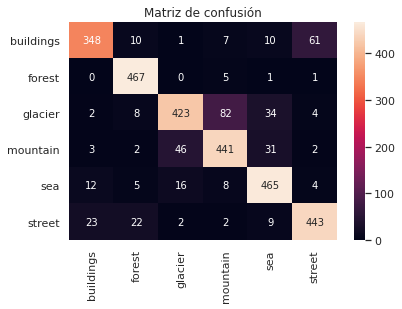

In [14]:
# Analizamos las predicciones de los datos de pruebas

predictions = modelLoad.predict(test_generator) # Vector de probabilidades
pred_labels = np.argmax(predictions, axis = 1) # Obtenemos la predicción con mas probabilidad
class_names = test_generator.class_indices.keys() # Nombre de las etiquetas

CM = confusion_matrix(test_generator.classes, pred_labels) # Matriz de confusión

ax = plt.axes()
sn.heatmap(CM, annot= True, 
           annot_kws={"size": 10}, 
           xticklabels= class_names, 
           yticklabels= class_names, 
           ax = ax,
           fmt= "d")
ax.set_title('Matriz de confusión')
plt.show()

In [15]:
# Función para obtener la etiqueta

def getcode(n) : 
    for x , y in train_generator.class_indices.items() : 
        if n == y : 
            return x 

In [24]:
# Usamos el modelo para predecir una imagen en concreto

img = image.load_img('../input/imagenes/test/sea/20305.jpg', target_size = (150, 150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predict = modelLoad.predict(img)
print('Predicción de la imagen: ' + getcode(np.argmax(predict)))

Predicción de la imagen: sea
